<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<center><img src='https://support.dreem.com/hc/article_attachments/360030317792/Dreem_Logo_RGB.png' width=200></center>
<h6><center><b>Machine Learning</b></center></h6>

<h6><center><b>ABBAHADDOU Yassine</b></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Dreem 2 Sleep Classification challenge 2020</center>
<hr style=" border:none; height:3px;">
</h1>






## Introduction <a class="anchor" id="first-bullet"></a>

Le sommeil est indispensable pour le bon fonctionnement de votre corps notamment pour assurer le renouvellement des cellules. Il est donc essentiel de comprendre ce qui en détermine précisément la qualité ou la durée de notre sommeil.

En principe, le sommeil correspond à une succession de 4 à 6 cycles d'environ 90 minutes chacun.  Un cycle est lui-même constitué d'une alternance de **sommeil lent** et de **sommeil paradoxal**, correspondant chacun à une activité cérébrale différente mise en évidence par **électroencéphalographie (EEG)** :

<center>
<img src="https://i.ibb.co/5Ftnp9M/Capture-1.png">
</center>


D'après l'hypnoramme ci-dessus, le sommeil lent comporte principalement 3 stades : après une **phase de transition (N1)** de quelques minutes, séparant la veille et le sommeil, la **phase de sommeil léger (N2)** s'installe. Elle est suivie par une phase de sommeil progressivement plus **profond (N3)** qui dure plusieurs dizaines de minutes. Le cycle se termine ensuite par du **sommeil paradoxal**. Il est aussi appelé période **REM (Rapid Eye Movement)**, en raison de fréquents mouvements oculaires rapides 

Il existe aujourd’hui des technologies intégrées à nos smartphones capables de mesurer et analyser les phases du sommeil. Nous nous interesserons plus particulièrement au fonctionnement du bandeau **Dreem 2** qui permet de mesurer l'activité cérébrale en temps réel.

<center>
<img src = "https://renight-store.com/img/cms/Capture%20d%E2%80%99%C3%A9cran%202020-04-02%20%C3%A0%2010-54-31.png" width =500>
</center>


Le bandeau Dreem analyse le sommeil grâce à ses nombreux capteurs : 
   * 7 électrodes EEG (4 électrodes frontales, 3 électrodes arrière) qui permet de mesurer l'activité celebrale par des signaux de fréquence 50 Hz (1500 = 50 x 30 valeurs par électrode pendant 30 sec).
   * Un oxymètre de pouls qui permet de mesurer le rythme cardiaque par des signaux de fréquence 10 Hz (300 = 10 x 30 valeurs pendant 30 sec).
   * 3 accéléromètres afin de mesurer les mouvements et la fréquence respiratoire par des signaux de fréquence 10 Hz (300 = 10 x 30 valeurs par accéléromètre pendant 30 sec).

## But du challenge <a class="anchor" id="second-bullet"></a>

Toutes les 30 secondes, on doit prédir dans quelle phase de sommeil se trouve une personnes en se basant uniquement sur les signaux (activité cérébrale, fréquence cardiaque, fréquence respiratoire, position etc… ) enregistrés par le bandeau pendant cet intervalle de temps. 

Il s'agit donc d'un problème de classification qui revient à attribuer à chaque entrée un label correspondant aux 5 phases du sommeil :
   * 0 pour éveil
   * 1 pour sommeil léger N1
   * 2 pour sommeil léger N2 
   * 3 pour sommeil léger N3 
   * 4 pour sommeil paradoxal REM 

## Chargement et traitement des données <a class="anchor" id="third-bullet"></a>

 ### 1 - Packages


In [ ]:
# Lecture et traitement des données
import numpy as np
import pandas as pd
import h5py
from keras.utils.np_utils import to_categorical  
from collections import Counter 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.vis_utils import plot_model

# Deep learning
from keras import models
from keras.optimizers import Adam
from keras import activations
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM, Reshape, Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping


### 2 - Chargement des données

Les données sont stockés sous le format **HDF5** permettant de sauvegarder et de structurer des fichiers contenant de très grandes quantités de données. (11703 features et 24688 données pour l'entrainement). 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/CS/Kaggle/"

Mounted at /content/gdrive


In [ ]:
# Data d'entrainement sous forme de signaux 
data_train = h5py.File(path+'X_train.h5', 'r')
# Labels de la data d'entrainement
y_train    = pd.read_csv(path + "y_train.csv")
# Data de test sans labels sous forme de signaux 
data_test  = h5py.File(path+'X_test.h5', 'r')
# Fichier de soumission
submission = pd.read_csv(path + 'sample_submission.csv')

Nous avons utiliser le package **h5py** pour lire ces fichiers, et nous avons ensuite sotcké les valeurs dans les tableaux numpy :
   * **X_train** (train set) et **X_test** (test set) : Concatenation des enregistrement des 11 signaux décris en introduction.
   * **y_train** : Les labels associés aux données d'entrainement et qui correspondent aux phases du sommeil (0 pour évail, 1 pour sommeil léger N1, 2 pour sommeil léger N2 , 3 pour sommeil léger N3, 4 pour sommeil paradoxal REM ).  


In [ ]:
# Concatenation des données
X_train = np.hstack((data_train['eeg_1'], data_train['eeg_2'], data_train['eeg_3'],data_train['eeg_4'],data_train['eeg_5'],data_train['eeg_6'],data_train['eeg_7'],data_train['x'],data_train['y'],data_train['z'],data_train['pulse']))
X_train = np.concatenate([X_train,np.zeros((24688,300))], axis=1)

X_test = np.hstack((data_test['eeg_1'], data_test['eeg_2'], data_test['eeg_3'],data_test['eeg_4'],data_test['eeg_5'],data_test['eeg_6'],data_test['eeg_7'],data_test['x'],data_test['y'],data_test['z'],data_test['pulse']))
X_test = np.concatenate([X_test,np.zeros((24980,300))], axis=1)

Concernant les labels, nous avons utiliser l'**Encodage one-hot**. L'avantage principal de cet encodage c'est que nous disposons des probabilités d'apprtenance d'une signal à chaqune des 5 classes.

In [ ]:
y_train = to_categorical(y_train['sleep_stage'], num_classes=5)

### 3 - Visusalisation des données


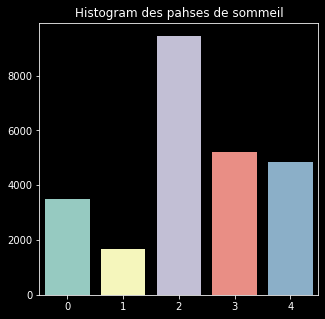

In [ ]:
# Histogram des pahses de sommeil

count = Counter(list(pd.read_csv(path + "y_train.csv")['sleep_stage']))

labels_ = list(count.keys())
labels_counts = list(count.values())

plt.style.use('dark_background')
plt.figure(figsize=(5, 5))

sns.barplot(x=labels_, y=labels_counts)
plt.title('Histogram des pahses de sommeil');

Text(0.5, 1.0, '                 pulse')

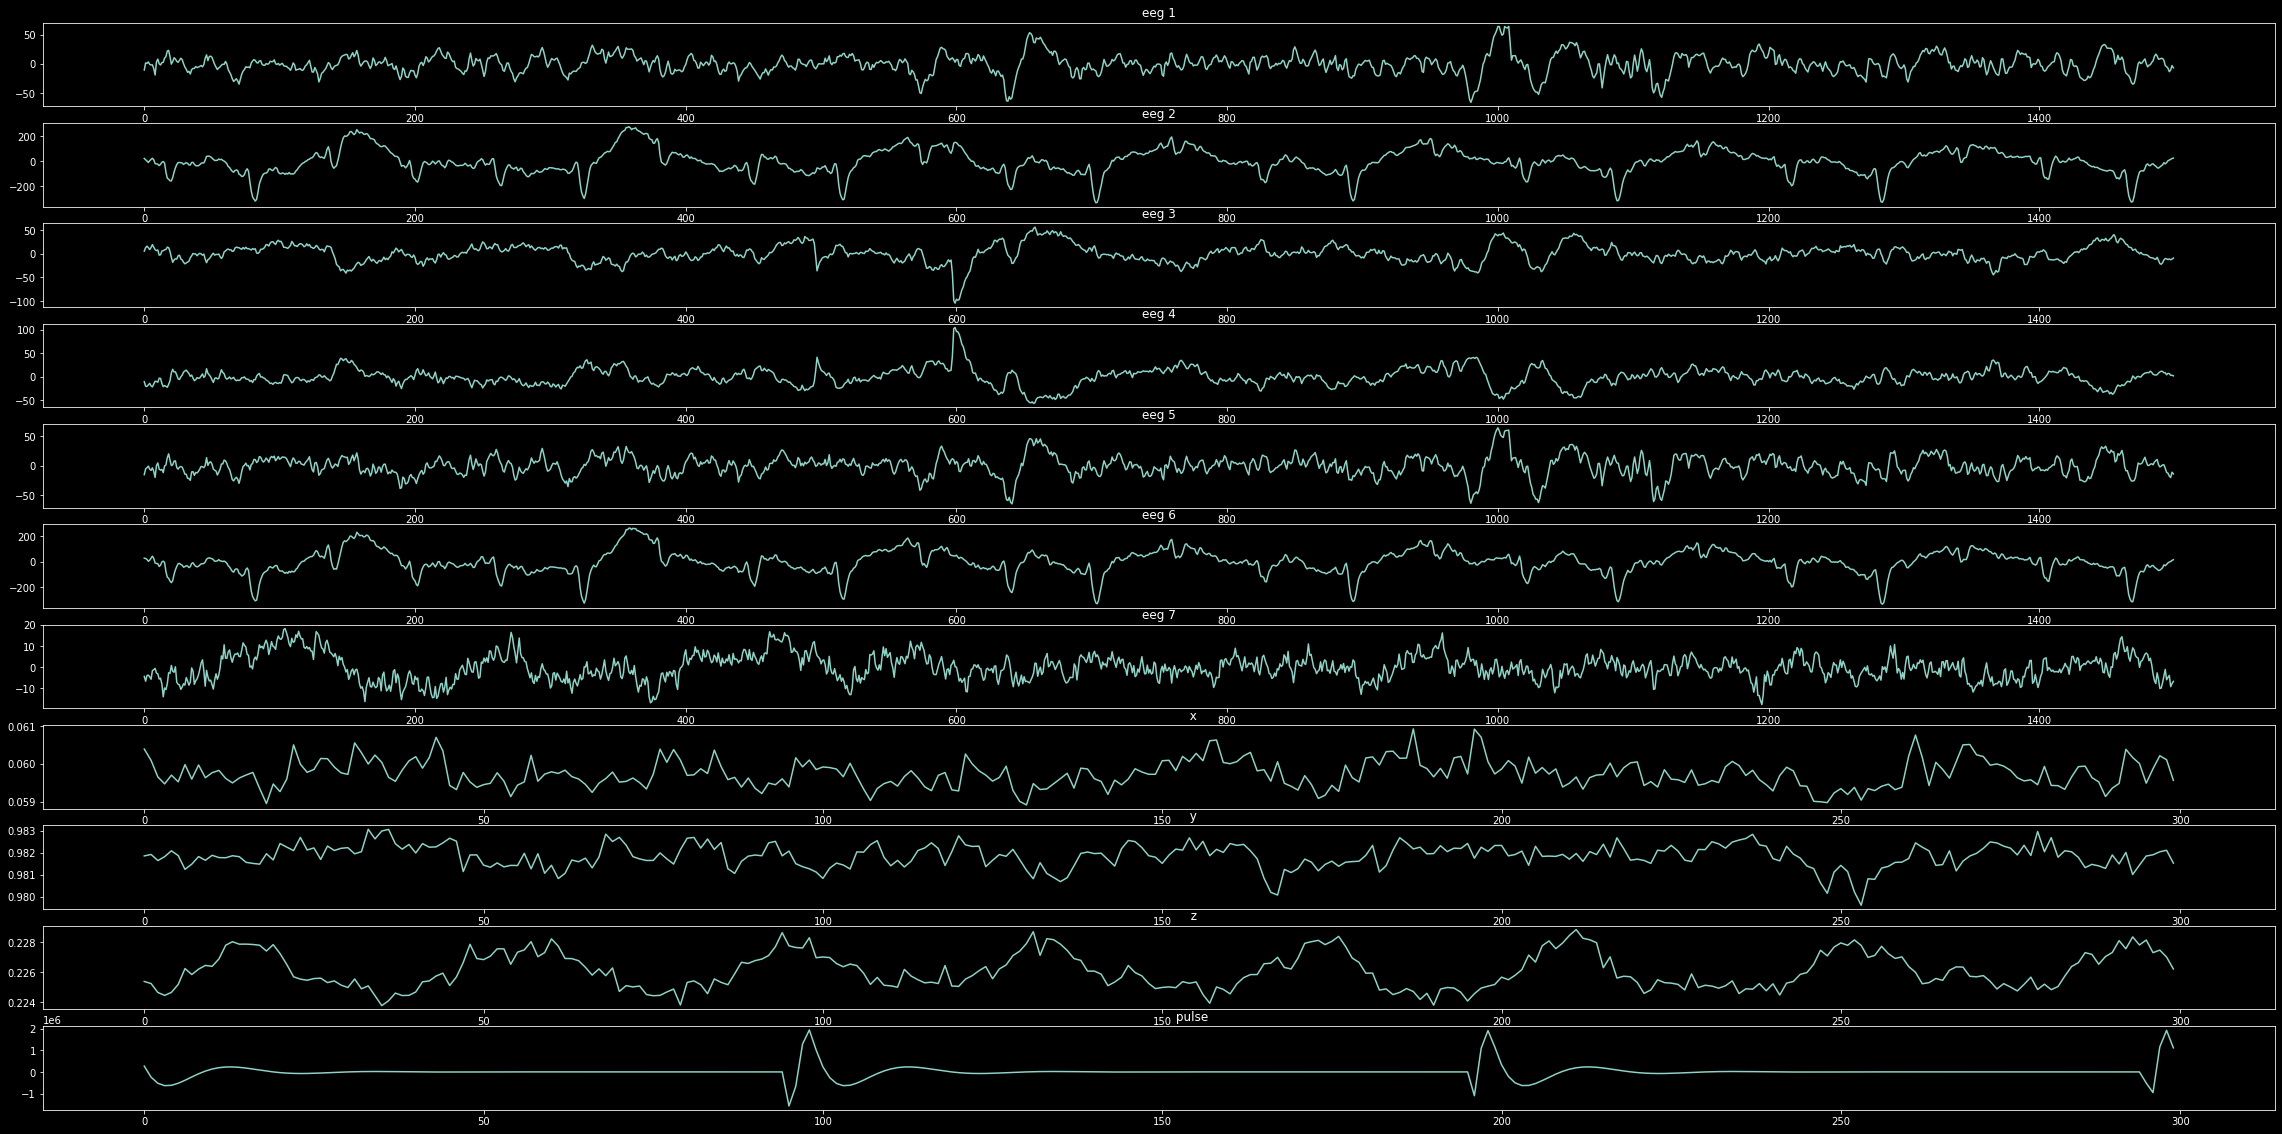

In [ ]:
# Allures des signaux

n = X_train.shape[0]
random_i = np.random.randint(n)
fig, axs = plt.subplots(11,figsize=(40, 20))
for k in range(7) :
  axs[k].plot(list(data_train['eeg_'+str(k+1)][random_i]))
  axs[k].set_title('eeg '+str(k+1))
axs[7].plot(list(data_train['x'][random_i]))
axs[7].set_title('                  x')
axs[8].plot(list(data_train['y'][random_i]))
axs[8].set_title('                  y')
axs[9].plot(list(data_train['z'][random_i]))
axs[9].set_title('                  z')
axs[10].plot(list(data_train['pulse'][random_i]))
axs[10].set_title('                 pulse')

## Choix du modèle <a class="anchor" id="third-bullet"></a>

 ### 1 - Choix du Deep Learning

Le **deep learning** ou **apprentissage profond** est un type d'intelligence artificielle dérivé du machine learning. Il s'appuie sur un réseau de neurones artificiels s'inspirant du cerveau humain. Un réseau de neuronnes est composé de plusieurs  couches de neurones, chacune recevant et interprétant les informations de la couche précédente. Comme à l'intérieur du cerveau humain, les signaux voyagent entre les neurones du cerveau artificiel. 


<center>
<img src="https://miro.medium.com/max/453/1*51D0MqtqHu3h2vTE5oJ-7g.png">
</center>

Nous avons décidé d'utiliser un modèle de Deep Learning pour les raisons suivantes :
  * **La grande dimension des données :** Pour chaque donnée, nous disposons de $11700$ entrées ($1500 \times 7 + 300 \times 4$). Les techniques du Deep Learning sont très permormantes lorseque la dimension des données est très grandes (Par exemple : Classification d'images, NLP, Signaux, Graphs .... ).  
  * **La tailles des données :** Contrairement au Deep Learning, les méthodes classiques du Machine Learning ne sont pas très performantes pour des problèmes avec un grand nombre de données (A cause du sur-apprentissage). Or, comme nous disposons de $24688$ donnés pour l'entrainement, l'utilsation d'un réseau de neuronnes sera donc plus bénefique.
  <center>
  <img src="https://i.ibb.co/xGQJtBg/t-l-chargement-1.jpg" >
</center>
  * **Extraction des données utiles :** Lors de l'entrainement, le réseau de neuronnes extracte lui même les données utiles. On n'a donc pas besoin de faire une réduction de dimension ou traintement des signaux.
  
    <center>
  <img src="https://talks.navixy.com/wp-content/uploads/2020/06/2-51.png " width =300>
</center>
  * **Le temps d'entrainement du modèle :** Vu la taille et la dimensions des données, les méthodes classiques ML prennent plusieurs heures pour s'entrainner parce que ce sont des méthodes itératives (La complexité dépend la taille et la dimensions des données). Alors que l'entrainement d'un réseau de neuronnes utilise des méthodes d'optimisation (Gradien descent, Stochastic Gradient Descent, Adam...), on peux donc minimiser le temps d'entrainement en entrainnant le modèle plusieurs fois (plusieurs epochs) sur des batchs différentes.  En utilisant un GPU, le temps d'entrainnement du modèle ne dépasse pas quelque secondes.

 ### 2 - Le modèle 

Les réseaux de neurones convolutifs unidimensionnels, ou CNN 1D, se sont avérées fournir des résultats de pointe sur des tâches comme la classification des signaux ou séries chronologiques .

Une architecture de réseau de neurones convolutifs est formée par un empilement de couches de traitement :
  * **la couche de convolution :** Elle consite à appliquer un filtre de convolution à l'input pour détecter ses caractérisques. Une donnée sous forme de tableau passe à travers une succession de filtres, ou noyaux de convolution, créant de nouvelles tableaus appelées cartes de convolutions. Au final, les cartes de convolutions sont mises à plat et concaténées en un vecteur de caractéristiques.
<center>
  <img src="https://miro.medium.com/max/500/1*Ff6mG3aPdWFkjb6hZPy3Xw.gif" width =200>
</center>
  * **la couche de pooling :** qui consiste à reduire progressivement la taille de les signaux en ne gardant que les informations les plus importantes, par exemple pour chaque groupe de 4 cases du tableau, la case ayant la valeur maximale (Max Pooling, le plus populaire) ou la moyenne des valeurs des cases (AVG pooling).
<center>
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Max_pooling.png/220px-Max_pooling.png" >
</center>
  * **la couche de correction RELU:** on fait passer les cartes de convolution à travers une couche d’activation non linéaire telle que **Rectified Linear Unit** (ReLu), qui consiste à remplacer les nombres négatifs des tableaux filtrées par des zéros. On utilise un fonction non linèaire vu que notre problème n'est pas linèaire.
  * **Couche entierement connectée :** Cette couche permet de réduire la dimnsion. On applique ensuite la fonction **Softmax** aux sorties de la couche fully connection pour avoir la probabilité de chaque classe.
  <center>
  <img src="https://miro.medium.com/max/441/1*5ZJRH0oMeW60Jdsidx_w1w.png" width =190 >
</center>

In [ ]:
def Model(p_dropout):
    
  model = Sequential()

  model.add(Reshape((1500, 8), input_shape=(12000,) ))

  model.add(Conv1D(16, 3, activation=activations.relu ))
  model.add(Conv1D(16, 3, activation=activations.softsign))


  model.add(MaxPooling1D(3))
  model.add(Conv1D(32, 3, activation=activations.relu))
  model.add(Conv1D(32, 3, activation=activations.selu))

  model.add(Dropout(0.2))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, activation=activations.relu))
  model.add(Conv1D(64, 2, activation=activations.softsign))

  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, activation=activations.relu))
  model.add(Conv1D(64, 2, activation=activations.softsign))


  model.add(GlobalAveragePooling1D())

  model.add(Dropout(p_dropout))
  model.add(Dense(64, activation=activations.relu))

  model.add(Dense(5, activation=activations.softmax))
  return model

In [ ]:
model  = Model(p_dropout=0.2)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1500, 8)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1498, 16)          400       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1496, 16)          784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 498, 16)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 496, 32)           1568      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 494, 32)           3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 494, 32)          

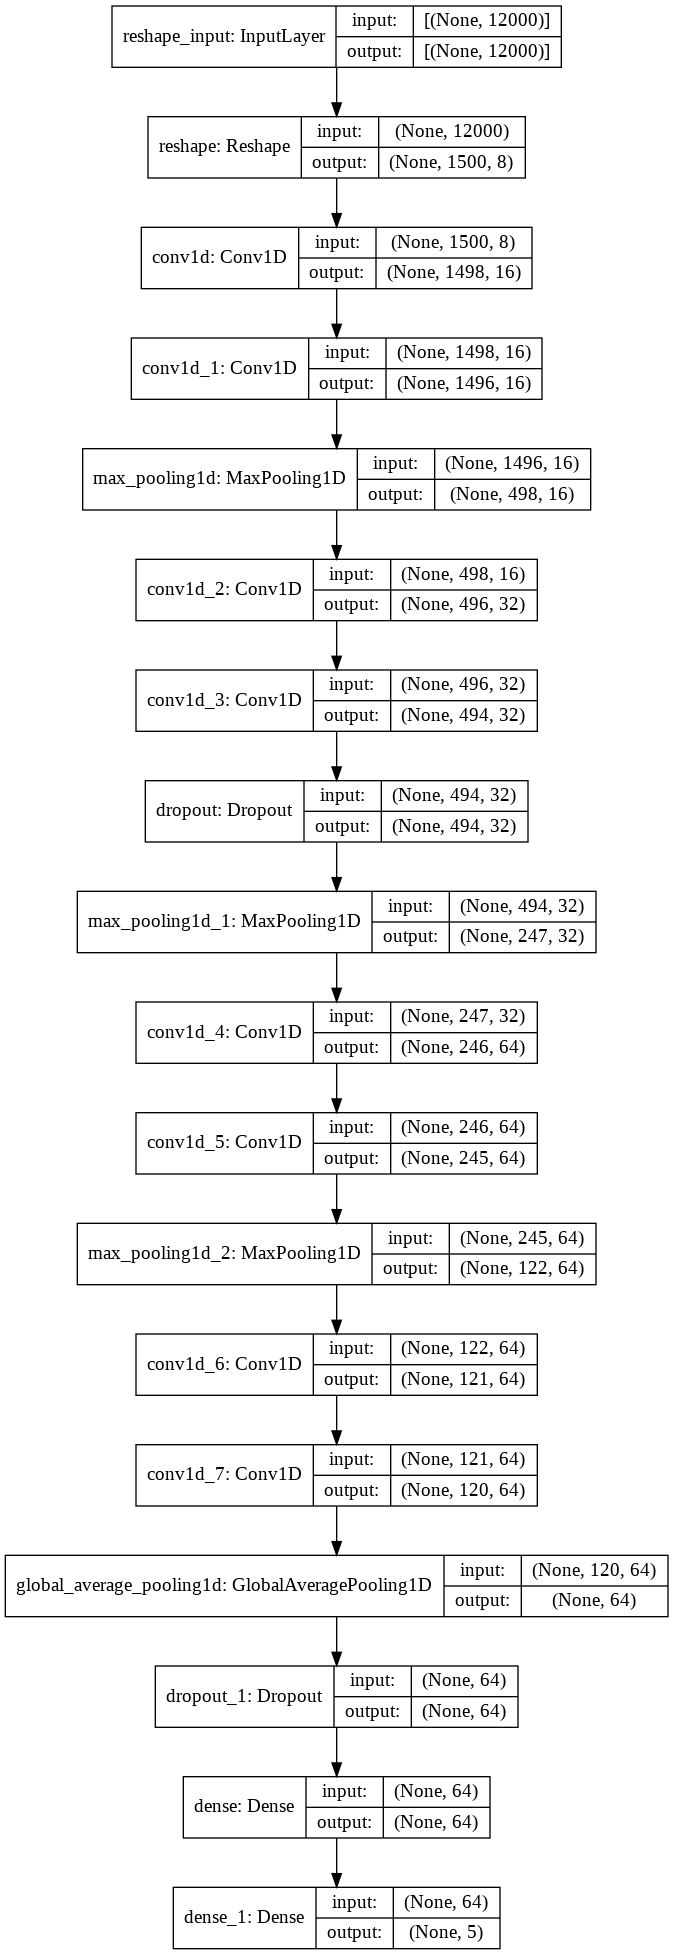

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

 ### 3 - Éviter le surapprentissage 

 Puisque nous utilisons un modèle très complexe, il y a un grand risque de sur-apprentissage. Le surapprentissage s'interprète comme un apprentissage « par cœur » des données, un genre de mémorisation. Il résulte souvent d'une trop grande liberté dans le choix du modèle.

 Pour éviter le surapprentissage le sur-apprentissage, nous utilisons :

  * **Division des données d'entrainnement:** Nous divisons les données d'entrainnement en deux parties : Une première partie (80%) utilisé pour entrainner le modèle et une deuxième partie (20%) pour valider le modèle et vérifier s'il est capable de bien classifier une entrée qu'il n'a jammais vu.
  * **Early Stopping :** Méthode de régularisation qui implique d'interrompre l'entraînement d'un modèle d'apprentissage lorsque la perte d'un ensemble de données de validation commence à augmenter et que les performances de généralisation se dégradent.
  <center>
  <img src="https://miro.medium.com/max/700/1*nhmPdWSGh3ziatQKOmVq0Q.png" width =400 >
</center>
  * **Utilisation de petits batchs :**  Au lieu de mettre à jour les paramètres du réseau pour un jeu d'entraînement d'environ 30000 exemples en une seul fois, nous utilisons une taille de batch de 32, il faudra 618 itérations pour effectuer un epoch, et plusieurs epoch pour converger. Cette méthodes permet de réduire la capacité pour prévenir l’Overfitting

  * **Dropout :**  une technique de régularisation pour réduire le surajustement dans les réseaux de neurones. A chaque epoch, on n'utilise qu'un pourcentage des noeuds d'une couche.

 ### 4 - Entrainement du modèle

 Durant l'entrainement, nous enregistrons le modèle aprés chaque epoch si ce dernier donne uns précision meilleur que celles du dernier modèle enregistré. Le dernier modèle enregistré correspond donc à notre modèle final (Early stopping).

Nous évaluons notre modèles par l'erreur de classification **Cross-entropy loss function** et la précision. Nous utilisons la méthode d'optimisation **Adam** pour mettre à jour les paramètres du réseau (L'algorithm d'Adam diminue le risque de rester dans minimum locaux).

In [ ]:
# Hyperparameters 
loss_function = 'categorical_crossentropy'
lr = 0.001
optimizer = Adam(learning_rate=lr)
metric = 'accuracy'

In [ ]:
# Trainning the model
model.compile(loss=loss_function,optimizer=optimizer, metrics=[metric])

training = model.fit(X_train,y_train,batch_size=32,epochs=100,callbacks=[ ModelCheckpoint(filepath='best_model.{epoch}.h5',
        monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='acc', patience=10)],validation_split=0.33,verbose=0 )

## 5 - Prédiciton des classes pour les données test :

In [ ]:
model_ = models.load_model('/content/best_model.52.h5')
y_pred = model_.predict(X_test)
submission.sleep_stage = y_pred.argmax(axis=1) 
submission.to_csv("submission.csv", index=False)

## 6 - Résultats

Vérifions l'évolution de la précision ainsi que l'erreur de prédicion :


In [ ]:
hist = training.history
len = len(hist[list(hist.keys())[0]])

Text(0.5, 1.0, 'categorical_crossentropy Loss ')

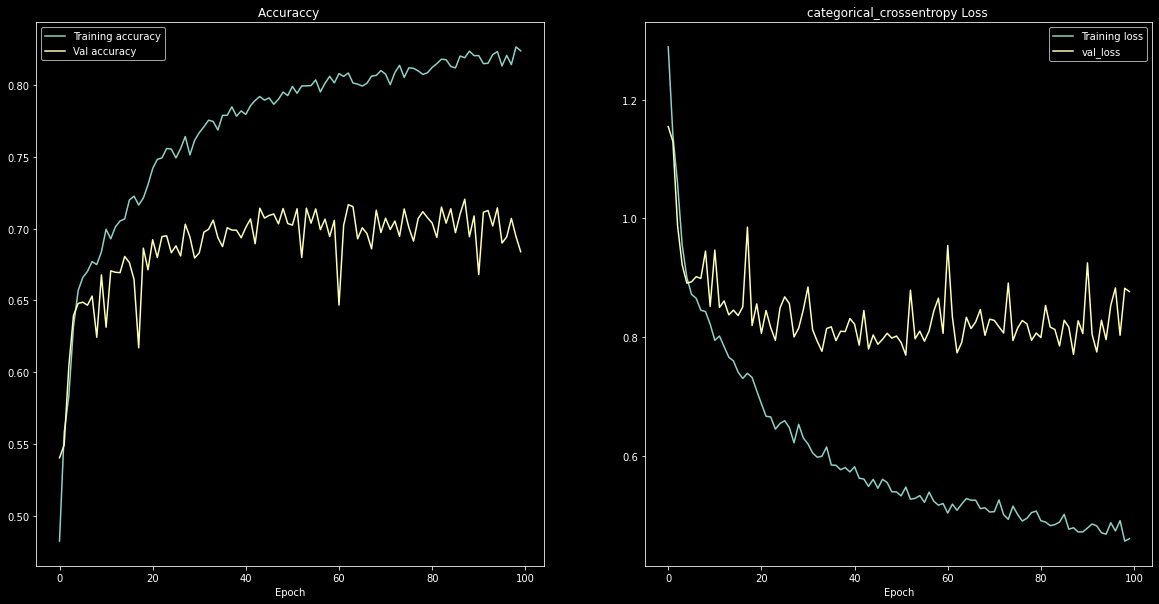

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
## == Accuracy
ax1.plot(np.arange(len), hist["accuracy"], label ="Training accuracy")
ax1.plot(np.arange(len), hist["val_accuracy"], label ="Val accuracy")
ax1.legend()
ax1.set(xlabel = "Epoch")
ax1.set_title("Accuraccy ")
## == Loss
ax2.plot(np.arange(len), hist["loss"], label ="Training loss")
ax2.plot(np.arange(len), hist["val_loss"], label ="val_loss")
ax2.legend()
ax2.set(xlabel = "Epoch")
ax2.set_title("categorical_crossentropy Loss ")

En utilisant le dernier modèle enregistré, nous obtenons le résultat suivant : 

|Tarinning Accuracy|Validation Accuracy|Tarinning Loss|Validation Loss|Kaggle Accuracy|
|------------------|-------------------|--------------|---------------|---------------|
|  88%             | 69,99%            |   0.32       |      1.02     |        72.5%  |

# Conclusion

Nous concluons que  :

  * Le temps d'entrainnement de notre modèle ne dure que quelques secondes (Avec GPU, quelques minutes sans GPU)
  * Notre modèle inclus le traitement du signal et l'extraction des données utiles
  * Même si le modèle est complexe, on réduit sa capacité pour prévenir l’Overfitting en utilisant des mini-batches  et l'Early stopping
  * Notre modèle prédit bien les pahses de sommeil (TOP 3 dans Kaggle)
